<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
4. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, TimeDistributed, CategoryEncoding, SimpleRNN, Bidirectional, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.optimizers import Adam, RMSprop, SGD

### 1. Datos

Se utilizará el cuento _El corazón delator_ de Edgar Allan Poe.

In [2]:
import urllib.request
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/edgar-allan-poe/el-corazon-delator/ebook')
raw_html = raw_html.read()

In [4]:
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:3000]

' ¡es verdad! nervioso, muy, muy terriblemente nervioso yo había sido y\r\n soy; ¿pero por qué dirán ustedes que soy loco? la enfermedad había \r\naguzado mis sentidos, no destruido, no entorpecido. sobre todo estaba la\r\n penetrante capacidad de oír. yo oí todas las cosas en el cielo y en la \r\ntierra. yo oí muchas cosas en el infierno. ¿cómo entonces soy yo loco? \r\n¡escuchen! y observen cuan razonablemente, cuan serenamente, puedo \r\ncontarles toda la historia. es imposible decir cómo primero la idea entró en mi cerebro, pero, \r\nuna vez concebida, me acosó día y noche. objeto no había ninguno. pasión\r\n no había ninguna. yo amé al viejo. el nunca me había hecho mal. él no \r\nme había insultado. de su oro no tuve ningún deseo. ¡creo que fue su ojo! sí, ¡fue eso! \r\nuno de sus ojos parecía como el de un buitre — un ojo azul pálido con \r\nuna nube encima. cada vez que caía sobre mí, la sangre se me helaba, y entonces de a \r\npoco, muy gradualmente, me decidí a tomar la vida 

#### Tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

- Tamaño de contexto

In [6]:
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
chars_vocab = set(article_text)

In [9]:
print("La longitud de vocabulario de caracteres es:", len(chars_vocab))

La longitud de vocabulario de caracteres es: 57


- `chars_vocab` : conjunto único de caracteres que existe en todo el texto

In [10]:
# chars_vocab

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  2. Preprocesamiento

**Tokenizamos el texto completo**

In [12]:
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
# tokenized_text[:1000]

#### Organizando y estructurando el dataset

In [14]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

- División de datos para entrenamiento y validación

In [15]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [16]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [17]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [18]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
X.shape

(11387, 100)

In [20]:
X[0,:10]

array([22, 51,  9, 18, 22, 11,  9, 10,  4, 37])

In [21]:
y[0,:10]

array([51,  9, 18, 22, 11,  9, 10,  4, 37,  4])

In [22]:
vocab_size = len(chars_vocab)

### Perplexity

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [23]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### 3. Arquitecturas

#### Modelo 1 - SimpleRNN

In [55]:
model = Sequential()

model.add(Input(shape=(None, 1)))
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")))
model.add(Bidirectional(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 57)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 400)      │       103,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 57)       │        22,857 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,057 (492.41 KB)

 Trainable params: 126,057 (492.41 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento

En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.

In [56]:
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 2.7465
 mean perplexity: 24.379968643188477 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - loss: 2.7319
Epoch 2/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8126
 mean perplexity: 19.718557357788086 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.8054
Epoch 3/10
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3615
 mean perplexity: 17.43984603881836 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3592
Epoch 4/10
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2580
 mean perplexity: 16.752538681030273 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2572
Epoch 5/10
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2203
 mean perplexity: 17.408039093017578 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2198
Epoch 6/10
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1978
 mean perplexity: 17.223106384277344 

45/45 ━━━━━━━━━━━━━━━━━━━

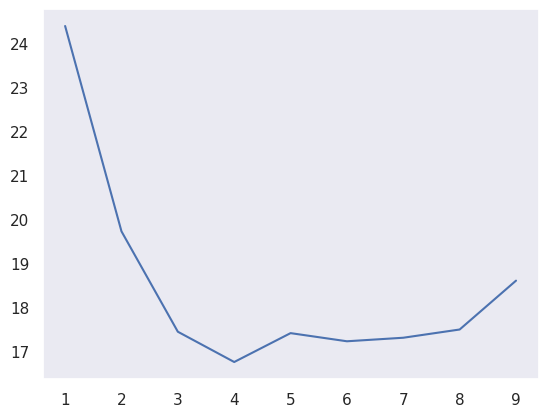

In [57]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [58]:
model.save("modelo_simpleRNN.keras")

#### Modelo 2 - LSTM

In [24]:
lstm = Sequential()

lstm.add(Input(shape=(None, 1)))
lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")))
lstm.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(vocab_size, activation='softmax'))

lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 57)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 256)      │       321,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 57)       │        14,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,185 (1.28 MB)

 Trainable params: 336,185 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_ppl = []
hist = lstm.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 2.9570
 mean perplexity: 32.74723815917969 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - loss: 2.9565
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 2.8192
 mean perplexity: 28.806678771972656 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - loss: 2.8182
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 2.6646
 mean perplexity: 26.346044540405273 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - loss: 2.6639
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 2.5444
 mean perplexity: 25.351442337036133 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - loss: 2.5440
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 2.4691
 mean perplexity: 23.146039962768555 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - loss: 2.4687
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 2.4075
 mean perplexity: 24.7628536224365

Mean perplexity LSTM

In [30]:
history_ppl

[np.float32(32.74724),
 np.float32(28.806679),
 np.float32(26.346045),
 np.float32(25.351442),
 np.float32(23.14604),
 np.float32(24.762854),
 np.float32(22.505167),
 np.float32(22.745695),
 np.float32(22.368677),
 np.float32(21.404484)]

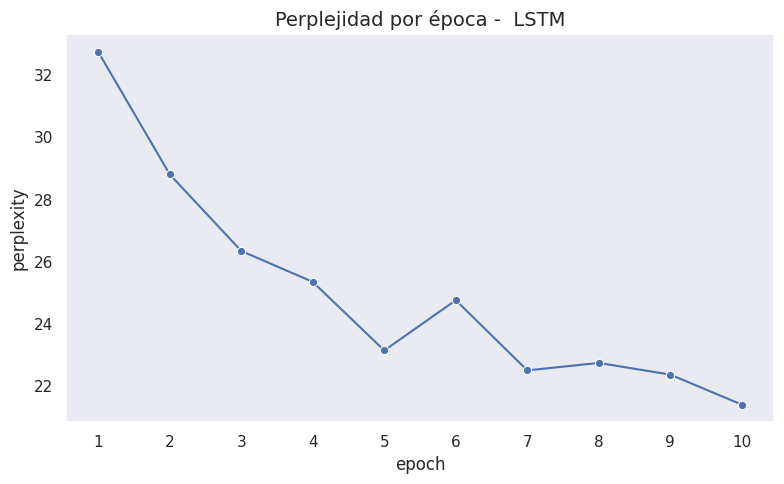

In [46]:
df_ppl = pd.DataFrame({
    'epoch': range(1, len(history_ppl) + 1),
    'perplexity': history_ppl
})

sns.set(style="dark")

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ppl, x='epoch', y='perplexity', marker='o')

plt.title("Perplejidad por época -  LSTM", fontsize=14)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("perplexity", fontsize=12)
plt.xticks(df_ppl['epoch'])
plt.tight_layout()
plt.show()


Guardar modelo

In [34]:
lstm.save("modelo_lstm.keras")

#### Modelo 3 - GRU

In [36]:
gru = Sequential()

gru.add(Input(shape=(None, 1)))
gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")))
gru.add(Bidirectional(GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
gru.add(Dense(vocab_size, activation='softmax'))

gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 57)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │       483,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 57)       │        29,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,081 (1.96 MB)

 Trainable params: 513,081 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_ppl = []
hist_gru = gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.4215
 mean perplexity: 26.5750789642334 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 3.4141  
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 2.4451
 mean perplexity: 24.195964813232422 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 2.4387
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 1.2736
 mean perplexity: 20.63549041748047 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - loss: 1.2699
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 0.7549
 mean perplexity: 17.901954650878906 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - loss: 0.7537
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 0.5750
 mean perplexity: 16.79906463623047 

Saved new model!
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - loss: 0.5745
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - loss: 0.4885
 mean perplexity: 16.140439987182617 


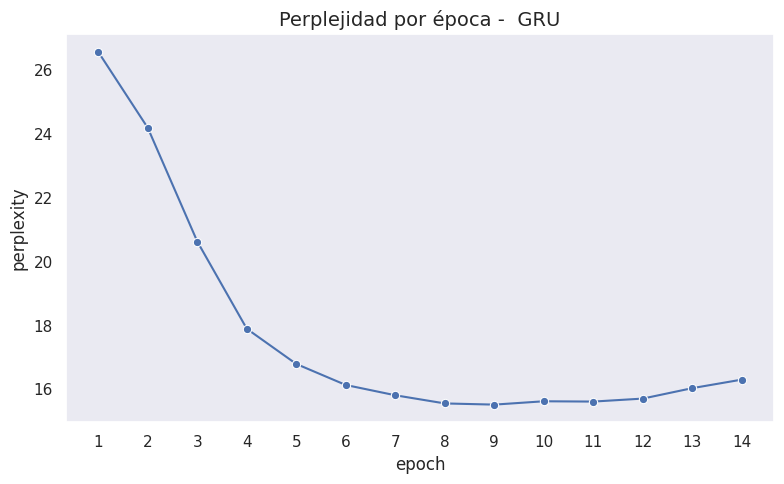

In [48]:
df_ppl = pd.DataFrame({
    'epoch': range(1, len(history_ppl) + 1),
    'perplexity': history_ppl
})

sns.set(style="dark")

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ppl, x='epoch', y='perplexity', marker='o')

plt.title("Perplejidad por época -  GRU", fontsize=14)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("perplexity", fontsize=12)
plt.xticks(df_ppl['epoch'])
plt.tight_layout()
plt.show()

In [49]:
gru.save("modelo_gru.keras")

**Comparación de Modelos Recurrentes GRU, LSTM y SimpleRNN**

`GRU`: este modelo muestra un descenso sostenido y pronunciado de la perplejidad en las primeras épocas, alcanzando su punto más bajo alrededor de la época 9. A partir de allí, la perplejidad se estabiliza con ligeras oscilaciones, lo que sugiere un entrenamiento efectivo y buena capacidad de generalización.

`LSTM`: también muestra una reducción consistente de la perplejidad, aunque en algunas épocas (como la 6) presenta aumentos puntuales, posiblemente indicativos de oscilaciones en el aprendizaje o un menor ajuste del modelo. Aun así, su rendimiento final es aceptable, aunque no tan estable como el GRU.

`SimpleRNN`: comienza con una perplejidad considerablemente más baja que los otros dos, pero tras una caída rápida inicial, el modelo parece estancarse y comienza a aumentar su perplejidad desde la época 5 o 6. Esto sugiere una menor capacidad de capturar dependencias temporales largas, lo que es un comportamiento esperado de SimpleRNN frente a LSTM o GRU.

El modelo **GRU** es el que presenta un mejor compromiso entre estabilidad y capacidad de aprendizaje a lo largo del entrenamiento, logrando una perplejidad más baja y sostenida. El modelo LSTM también tiene buen rendimiento, pero es algo menos estable. Finalmente, el modelo SimpleRNN muestra limitaciones claras para mantener una perplejidad baja en fases avanzadas del entrenamiento, lo que confirma su menor capacidad para secuencias complejas o largas.

Observaciones:
- al agregar capa Bidireccional a los modelos SimpleRNN y GRU presentaron una mejora significativa en el descenso de perplejidad.
- el modelo SimpleRNN se entrenó con el optimidazor `adam` pero no fue mejor que `rmsprop`.


**Posibles mejoras**

Para mejorar el desempeño de los modelos, se podrían ajustar los hiperparámetros como el tamaño de las capas o la cantidad de neuronas. Asimismo, agregar más capas recurrentes puede permitir al modelo aprender representaciones más complejas y jerárquicas del lenguaje, siempre teniendo cuidado de no sobreajustar. También se podría volver a entrenar con más épocas.

### 4. Generación de secuencias

Para este ejercicio se realiza generación de secuencias con el modelo GRU.

In [59]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('modelo_gru.keras')

**Greedy Search**

In [60]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [61]:
input_text='todas las cosas en el cielo'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'todas las cosas en el cielo \r\ncora so pora an en en en en'

**Beam search y muestreo aleatorio**

In [62]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [63]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
# num_beams : cantidad de ramas
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

'''
Beam_search mantiene n de beams de búsqueda.
'''
# temp=1 por defecto.
def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

**beam search determístico**

In [64]:
# predicción con beam search
salidas = beam_search(model, num_beams=10, num_words=20, input="todas las cosas en el cielo")

In [65]:
salidas[0]

array([41, 42,  4, 37, 18, 22, 17, 37, 18, 22,  5, 42, 18, 37, 18, 22,  9,
       47, 22,  9, 17, 22,  5,  0,  9, 17, 42, 22, 49, 21, 48, 42, 10, 37,
       22, 49, 21,  5, 42, 10, 37, 22, 49, 21,  5, 42, 10])

In [66]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

todas las cosas en el cielo 
pora 
cora 
cor
todas las cosas en el cielo 
pora 
cora 
per
todas las cosas en el cielo 
pora 
cora 
co 
todas las cosas en el cielo 
pora 
cora 
por
todas las cosas en el cielo 
pora 
cora 
con


**beam search estocástico**

In [81]:
salidas = beam_search(model, num_beams=10, num_words=20, input="todas las cosas en el cielo", mode='sto')

In [84]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

todas las cosas en el cielo to de con co do ded
todas las cosas en el cielo to de con cora qunt
todas las cosas en el cielo to de con co do dec
todas las cosas en el cielo to de con cora qun 
todas las cosas en el cielo to de con cora a pe
